# Catalog Optimization project

### Solution for catalog optimization using data from Corporacion Favorita Kaggle competition

### Notebook chapters:

    1.) Data source
    2.) Plotting geographical data (sidenote)
    3.) Solution for a single store
    4.) Solution for all stores

### 1.) Data source:

Corporacion Favorita Grocery Sales: https://www.kaggle.com/c/favorita-grocery-sales-forecasting

#### Data sets:
    1.) train[store_nbr, date, item_nbr, unit_sales]
    2.) test[store_nbr, date, item_nbr]
    3.) stores[city, state, type, cluster]
    4.) items[family, class, perishable]
    
#### Notes:

- The training data does not include rows for items that had zero unit_sales for a store/date combination. There is no information as to whether or not the item was in stock for the store on the date, and teams will need to decide the best way to handle that situation. Also, there are a small number of items seen in the training data that aren't seen in the test data.


- Training data spans more than 4.5 years: from January 2013 up to mid August 2017. In contrast, the test data covers the 16 days from August 16th until August 31st.


- The test data has a small number of items that are not contained in the training data. Part of the exercise will be to predict a new item sales based on similar products.


- Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.

In [164]:
import pandas as pd 
import numpy as np
from collections import deque
from io import StringIO
import os
import time
from datetime import datetime
import geojson
import geopandas as gpd
import geoplot as gplt
from shapely.geometry import Point

In [ ]:
from contextlib import contextmanager

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [ ]:
path = os.getcwd() + '/data/'

def get_csv_head_and_tail(filename, nr_of_rows = 2, header = 0):
    """ Read first and last n rows of a csv"""
    with open(filename, 'r') as f:
        t = deque(f, nr_of_rows)
        f.close()
        
    tail = pd.read_csv(StringIO(''.join(t)), header = None)    
    head = pd.read_csv(filename, nrows = nr_of_rows, header = header)
    
    if header is not None:
        tail.columns = head.columns
        
    return(head.append(tail))

get_csv_head_and_tail(path + 'train.csv')

In [3]:
path = os.getcwd() + '/data/'
dtypes = {'id':'uint32', 'item_nbr':'int32', 'store_nbr':'int8', 'onpromotion': 'bool'}

# read only 2016-2017 data
df_train = pd.read_csv(path + 'train.csv',
                       usecols=[1, 2, 3, 4, 5],
                       dtype=dtypes,
                       parse_dates=['date'],
                       low_memory = False,
                       skiprows=range(1, 66458909))

items = pd.read_csv(path+"items.csv")
stores = pd.read_csv(path+"stores.csv")

#merge all data sets
data = pd.merge(df_train, items, how='left', on='item_nbr')
data = pd.merge(data, stores, how='left', on='store_nbr')

In [1015]:
data

,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,city,state,type,cluster,year,weekday,month
0,2016-01-01,25,105574,12.0,False,GROCERY I,1045,0,Salinas,Santa Elena,D,1,2016,4,1
1,2016-01-01,25,105575,9.0,False,GROCERY I,1045,0,Salinas,Santa Elena,D,1,2016,4,1
2,2016-01-01,25,105857,3.0,False,GROCERY I,1092,0,Salinas,Santa Elena,D,1,2016,4,1
3,2016-01-01,25,108634,3.0,False,GROCERY I,1075,0,Salinas,Santa Elena,D,1,2016,4,1
4,2016-01-01,25,108701,2.0,True,DELI,2644,1,Salinas,Santa Elena,D,1,2016,4,1
5,2016-01-01,25,108786,2.0,False,CLEANING,3044,0,Salinas,Santa Elena,D,1,2016,4,1
6,2016-01-01,25,108797,1.0,False,GROCERY I,1004,0,Salinas,Santa Elena,D,1,2016,4,1
7,2016-01-01,25,108952,12.0,False,CLEANING,3024,0,Salinas,Santa Elena,D,1,2016,4,1
8,2016-01-01,25,111397,5.0,False,GROCERY I,1072,0,Salinas,Santa Elena,D,1,2016,4,1
9,2016-01-01,25,114790,4.0,False,GROCERY I,1004,0,Salinas,Santa Elena,D,1,2016,4,1


#### Dataframes with additional information

In [888]:
# Helper df's to match an SKU to its family or class
sku_family_df = data.groupby(['item_nbr'])['family'].nth(0)
sku_class_df = data.groupby(['item_nbr'])['class'].nth(0)

# Df with information about stores
store_info_df = data.groupby(['store_nbr'])['cluster', 'type', 'city', 'state'].nth(0).reset_index()
store_info_df['state_upper'] = list(map(lambda x: x.upper(), store_info_df['state']))
store_info_df['city_upper'] = list(map(lambda x: x.upper(), store_info_df['city']))

### 2.) Sidenote: plotting maps in python

Libraries for plotting geospatial data:

    1.) geopandas
    2.) geoplot
    3.) folium
    
Libraries for manipulating geospatioal data:

    1.) geojson
    2.) shapely

In [612]:
# Spatial data can be in the form polygons (for administrative areas like states) or points, lines etc.
# Spatial data can be expressed using different coordinate systems, so special attention must be paid to use the 
# same system when plotting data from different sources 

# Read spatial data from geojson and store it in a geopandas df
ecuador_gdf = gpd.read_file('data/ecuador.geojson', encoding='utf-8')
ecuador_gdf = ecuador_gdf[ecuador_gdf['DPA_DESPRO'] != 'GALAPAGOS'].copy() # keep only mainland data
ecuador_gdf.drop(columns=['DPA_VALOR','DPA_ANIO','DPA_CANTON', 'DPA_PROVIN', 'PCODE2'], inplace=True)

# Match city point coordinates to province polygons
city_coords = pd.read_csv('data/city_coords.csv')
# Check if city (long, lat) is in province polygon
province = []
for point in cities_gdf['geometry']:
    province.append(ecuador_gdf[ecuador_gdf['geometry'].contains(point)]['DPA_DESCAN'].iloc[0])
city_coords['DPA_DESCAN'] = province

# Store spatial data in a dict as well
# Merge smaller boundaries into state boundaries
state_boundaries_gdf = ecuador_gdf[['DPA_DESPRO', 'geometry']].dissolve(by='DPA_DESPRO').reset_index()
def df_to_dict(df, key_col, value_col):
    dictionary = {}
    keys = df[key_col].unique()
    for key in keys:
        dictionary[key] = df.loc[df[key_col]==key][value_col].iloc[0]
    return dictionary

state_geo_dict = df_to_dict(state_boundaries_gdf, key_col='DPA_DESPRO', value_col='geometry')
province_geo_dict = df_to_dict(ecuador_gdf, key_col='DPA_DESCAN', value_col='geometry')

### Plot store locations

In [1017]:
# # Create geodataframe for store locations
city_coords = pd.read_csv('data/city_coords.csv')
store_location = store_info_df.merge(city_coords, on='city', how='left')
geometry = [Point(xy) for xy in zip(store_info['lat'], store_info['long'])]
store_location = GeoDataFrame(store_location, geometry=geometry)

import folium

color_dict = {'A':'green', 'B':'blue', 'C':'red', 'D':'black', 'E':'purple'}

m = folium.Map(
    location=[-1.70,  -78.467834],
    zoom_start=7,
    tiles='OpenStreetMap'
)
for index, row in store_location[['store_nbr', 'cluster', 'type', 'long', 'lat']].iterrows():
    folium.Marker(
        location=[row[3]+float(np.random.rand(1)/20), row[4]+float(np.random.rand(1)/20)],# randomness so points don't overlap
        popup='Store nr. = {}, Cluster = {}, Store type = {}'.format(row[0], row[1], row[2]),
        icon=folium.Icon(color=color_dict[row[2]], icon='shopping-basket', prefix='fa'),
    ).add_to(m)
m

In [604]:
sales_per_state = data.groupby(['state'])['unit_sales'].sum().reset_index()
sales_per_state.loc[:, 'state'] = list(map(lambda x: x.upper(), sales_per_state['state']))
sales_per_state.loc[:, 'unit_sales'] = np.log(sales_per_state['unit_sales'])
geometry = [state_geo_dict[x] for x in sales_per_state['state']]
sales_per_state = GeoDataFrame(sales_per_state, geometry=geometry)

In [614]:
sales_per_city = data.groupby(['city'])['unit_sales'].sum().reset_index()
sales_per_city.loc[:, 'unit_sales'] = np.log(sales_per_city['unit_sales'])
sales_per_city = sales_per_city.merge(city_coords, on='city', how='left')
geometry = [province_geo_dict[x] for x in sales_per_city['DPA_DESCAN']]
sales_per_city = GeoDataFrame(sales_per_city, geometry=geometry)

Text(0.5,1,'Total sales per province (2016-2017)')

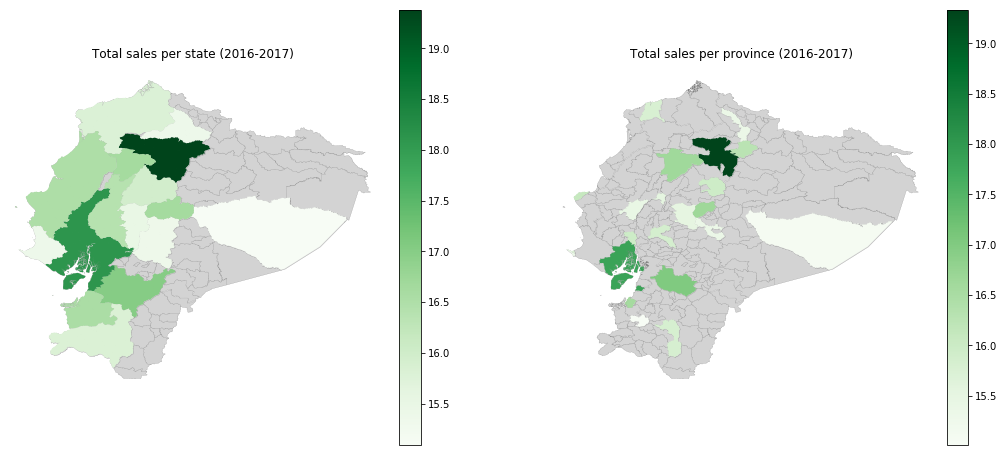

In [883]:
import geoplot.crs as gcrs
proj = gcrs.AlbersEqualArea()

state_boundaries_gdf['Ecuador'] = 'Ecuador'
country_boundaries = state_boundaries_gdf.dissolve(by='Ecuador')
xmin, ymin, xmax, ymax = country_boundaries['geometry'].iloc[0].bounds

fig = plt.figure(figsize=(18, 8))
ax1 = plt.subplot(121, projection=gcrs.AlbersEqualArea(central_latitude=-1.70, central_longitude=-78.46))
gplt.polyplot(ecuador_gdf,
              projection=proj,
              extent = (xmin, xmax, ymin, ymax),         
              facecolor='lightgray',
              edgecolor='gray',
              linewidth=0.2,
              ax=ax1)
gplt.choropleth(sales_per_state,
                projection=proj,
                extent = (xmin, xmax, ymin, ymax),
                hue=sales_per_state['unit_sales'],
                legend=True,
                cmap='Greens',
                linewidth=0.2, 
                k=None,
                figsize=(7, 5),
                ax=ax1)
ax1.set_title('Total sales per state (2016-2017)', pad=20)

ax2 = plt.subplot(122, projection=gcrs.AlbersEqualArea(central_latitude=-1.70, central_longitude=-78.46))
gplt.polyplot(ecuador_gdf,
              projection=proj,
              extent = (xmin, xmax, ymin, ymax),
              facecolor='lightgray',
              edgecolor='gray',
              linewidth=0.2,
              ax=ax2)
gplt.choropleth(sales_per_city,
                projection=proj,
                extent = (xmin, xmax, ymin, ymax),
                hue=sales_per_city['unit_sales'],
                legend=True,
                cmap='Greens',
                linewidth=0.2, 
                k=None,
                ax=ax2)
ax2.set_title('Total sales per province (2016-2017)', pad=20)

In [ ]:
#Count of stores in different types and clusters
plt.figure(figsize=(15,12))
plt.subplot(221)

# Count of stores for each type 
temp = stores['cluster'].value_counts()
#plot
sns.barplot(temp.index,temp.values,color=color[5])
plt.ylabel('Count of stores', fontsize=12)
plt.xlabel('Cluster', fontsize=12)
plt.title('Store distribution across cluster', fontsize=15)

plt.subplot(222)
# Count of stores for each type 
temp = stores['type'].value_counts()
#plot
sns.barplot(temp.index,temp.values,color=color[7])
plt.ylabel('Count of stores', fontsize=12)
plt.xlabel('Type of store', fontsize=12)
plt.title('Store distribution across store types', fontsize=15)

plt.subplot(223)
# Count of stores for each type 
temp = stores['state'].value_counts()
#plot
sns.barplot(temp.index,temp.values,color=color[8])
plt.ylabel('Count of stores', fontsize=12)
plt.xlabel('state', fontsize=12)
plt.title('Store distribution across states', fontsize=15)
plt.xticks(rotation='vertical')

plt.subplot(224)
# Count of stores for each type 
temp = stores['city'].value_counts()
#plot
sns.barplot(temp.index,temp.values,color=color[9])
plt.ylabel('Count of stores', fontsize=12)
plt.xlabel('City', fontsize=12)
plt.title('Store distribution across cities', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

In [972]:
stores_per_city = stores.groupby(['city'])['store_nbr'].count().sort_values(ascending=False)
stores_per_state = stores.groupby(['state'])['store_nbr'].count().sort_values(ascending=False)
stores_per_type = stores.groupby(['type'])['store_nbr'].count().sort_values(ascending=False)
stores_per_cluster = stores.groupby(['cluster'])['store_nbr'].count().sort_values(ascending=False)

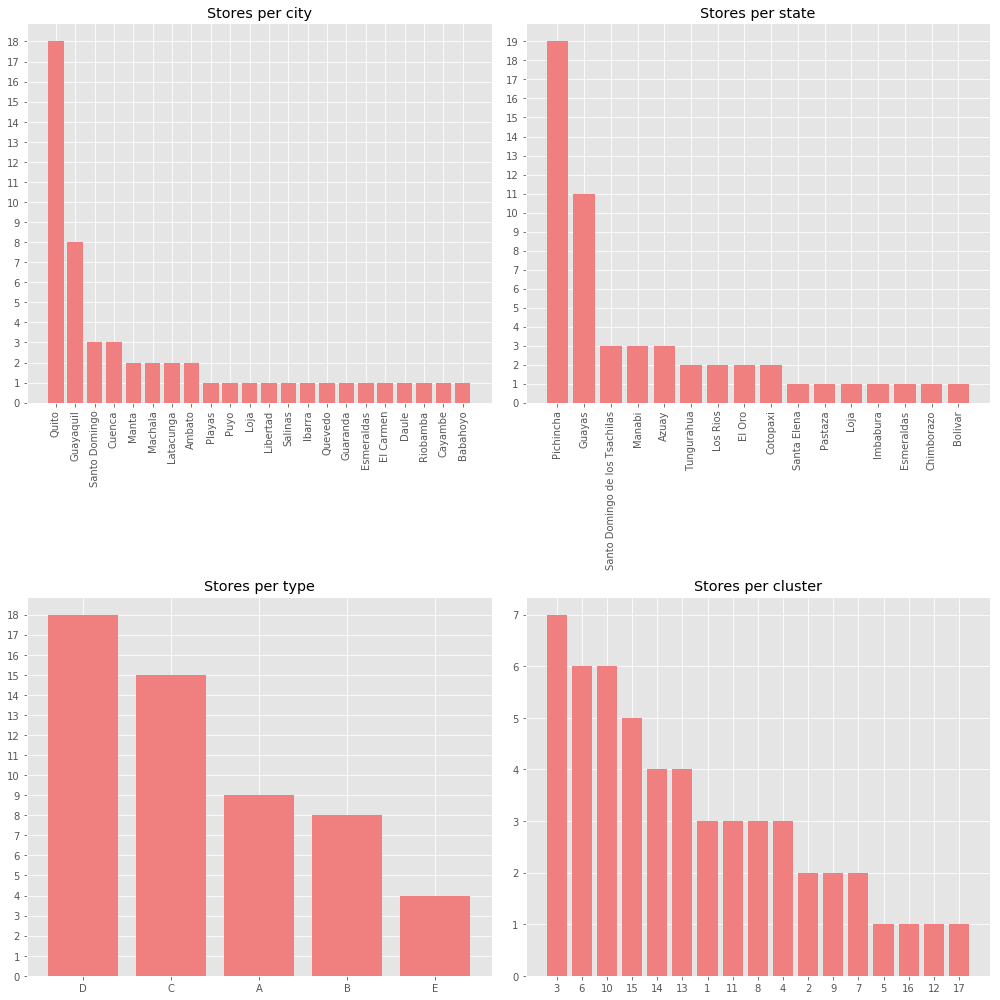

In [1014]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))
    ax = ax.flatten()

    ax[0].bar(stores_per_city.index, stores_per_city.values, color='lightcoral')
    ax[0].tick_params(axis='x', labelrotation = 90)
    ax[0].set_yticks(list(range(max(stores_per_city)+1)))
    ax[0].set_title('Stores per city')
    
    ax[1].bar(stores_per_state.index, stores_per_state.values, color='lightcoral')
    ax[1].tick_params(axis='x', labelrotation = 90)
    ax[1].set_yticks(list(range(max(stores_per_state)+1)))
    ax[1].set_title('Stores per state')
        
    ax[2].bar(stores_per_type.index, stores_per_type.values, color='lightcoral')
    ax[2].set_yticks(list(range(max(stores_per_type)+1)))
    ax[2].set_title('Stores per type')
    
    ax[3].bar(list(range(len(stores_per_cluster.index))), stores_per_cluster.values, color='lightcoral')
    ax[3].set_xticks(list(range(len(stores_per_cluster.index))))
    ax[3].set_xticklabels(stores_per_cluster.index)
    ax[3].set_yticks(list(range(max(stores_per_cluster)+1)))
    ax[3].set_title('Stores per cluster')
    
    plt.tight_layout()

##  1.) Catalogue optimization for a single store

First step is to develop a solution for a single store

In [8]:
def get_single_store_data(data, store_nbr):
    """Get data for a single store and create some helper columns"""
    store_data = data[data['store_nbr'] == store_nbr].copy()
    # Create new columns with date info
    store_data['year'] = list(map(lambda x: x.year, store_data.loc[:, 'date']))
    store_data['month'] = list(map(lambda x: x.month, store_data.loc[:, 'date']))
    store_data['day'] = list(map(lambda x: x.day, store_data.loc[:, 'date']))
    dow_dict = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
    store_data['day_of_week'] = list(map(lambda x: dow_dict[x.weekday()], store_data['date']))
    return store_data

# Lets choose store 47 as it has the highest revenue
store_nbr=47
store_data = get_single_store_data(data, store_nbr=store_nbr)

In [37]:
# Create a sale occurance matrix which will help us see when a certain product was introduced
def create_sale_occurance_matrix(data, data_type):
    """ Create a sale occurance matrix. Each column is an SKU and each row is a month. 
    Cells represent count of days where a sale occurred.
    
    Parameters
    ----------
    data : DataFrame
        Sales data (one store or all stores)    
    Return
    --------
    agg_df : DataFrame
    """
    
    if data_type == 'one_store':
        df_agg = data.groupby(['item_nbr', 'date'])['unit_sales'].count()
        df_agg = df_agg.unstack(level=0)
        df_agg = df_agg.resample('M').sum()
        return df_agg
    elif data_type == 'all_stores':
        df_agg = data.groupby(['store_nbr', 'item_nbr', 'date'])['unit_sales'].sum().unstack(level=1)
        level_values = df_agg.index.get_level_values
        df_agg = df_agg.groupby([level_values(0)]+[pd.Grouper(freq='M', level=-1)]).sum()
    return df_agg

df_agg = create_sale_occurance_matrix(store_data, data_type='one_store')

In [11]:
# Get month of fisrt occurance for each SKU
def get_month_of_first_appearance(df):
    """Return month of first appearance for all SKU's
    
    Parameters
    ----------
    df : DataFrame
        Sale count matrix where columns are SKU's and rows are counts of sale occurance in a month
    
    Return
    --------
    agg_df : dict
        Dictionary where keys are SKU's and values are months of first appearance
    """
    first_appearance = {}
    for item in df.columns:
        first_appearance[item] = (df[item] == 0).idxmin()
        
    return first_appearance

first_appearance = get_month_of_first_appearance(df_agg)

In [12]:
first_appearance

{96995: Timestamp('2017-03-31 00:00:00', freq='M'),
 99197: Timestamp('2016-05-31 00:00:00', freq='M'),
 103520: Timestamp('2016-01-31 00:00:00', freq='M'),
 103665: Timestamp('2016-01-31 00:00:00', freq='M'),
 105574: Timestamp('2016-01-31 00:00:00', freq='M'),
 105575: Timestamp('2016-01-31 00:00:00', freq='M'),
 105577: Timestamp('2016-01-31 00:00:00', freq='M'),
 105693: Timestamp('2016-01-31 00:00:00', freq='M'),
 105737: Timestamp('2016-01-31 00:00:00', freq='M'),
 105857: Timestamp('2016-01-31 00:00:00', freq='M'),
 106716: Timestamp('2016-01-31 00:00:00', freq='M'),
 108079: Timestamp('2016-01-31 00:00:00', freq='M'),
 108634: Timestamp('2016-01-31 00:00:00', freq='M'),
 108696: Timestamp('2016-01-31 00:00:00', freq='M'),
 108698: Timestamp('2016-01-31 00:00:00', freq='M'),
 108701: Timestamp('2016-01-31 00:00:00', freq='M'),
 108786: Timestamp('2016-01-31 00:00:00', freq='M'),
 108797: Timestamp('2016-01-31 00:00:00', freq='M'),
 108831: Timestamp('2016-01-31 00:00:00', freq='

In [14]:
from datetime import datetime

def get_new_products(first_appearance, date):
    """Get all products which were introduced in given month
    Ex: date = datetime(2017, 5, 31) returns all products introduced in May 2017
    
    Parameters
    ----------
    first_appearance : dict
        Dictionary where keys are SKU's and values are months of first appearance
    date : datetime
        Date when new products have been introduced 
        
    Return
    --------
    new_products : list
        List of products which have been introduced in given month
    """
    
    new_products = []
    for key, value in first_appearance.items():
        if value == date:
            new_products.append(key)
    return new_products

new_products = get_new_products(first_appearance, date=datetime(2017, 5, 31))

In [30]:
#The result is a list new products introduced in May
new_products[:5]

[1371395, 1421429, 2003392, 2053415, 2059647]

In [892]:
# Plot family and class of new products
import squarify

def get_class_and_family(sku_list):
    class_list = []
    family_list = []
    for sku in sku_list:
        class_list.append(sku_class_df[sku])
        family_list.append(sku_family_df[sku])
    df = pd.DataFrame({'SKU':sku_list, 'CLASS':class_list, 'FAMILY':family_list})
    return df

new_products_df = get_class_and_family(new_products)

Text(0.5,1,'Treemap of new product family')

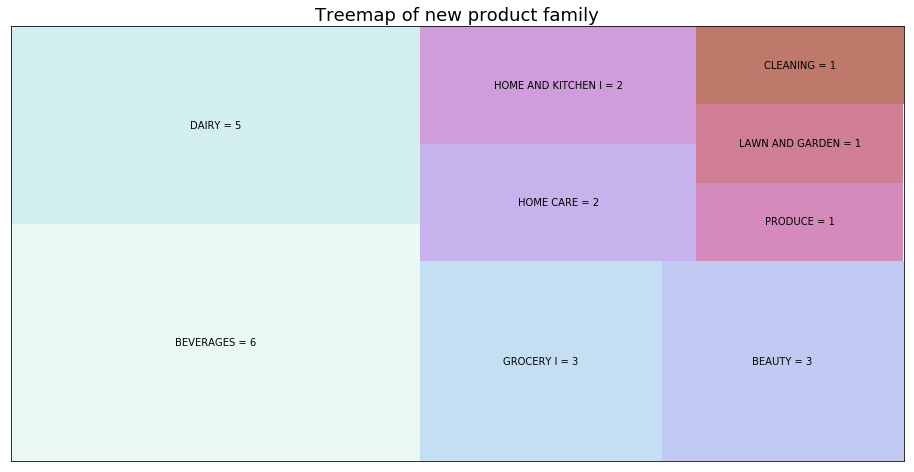

In [955]:
import squarify

items_per_family = new_products_df.groupby(['FAMILY'])['SKU'].count().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(16,8))
ax = squarify.plot(sizes=items_per_family.values,
              label=[str(x) + ' = {}'.format(items_per_family[x]) for x in items_per_family.index],
              color=sns.color_palette('cubehelix_r', items_per_family.shape[0]+10),
              alpha=1)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Treemap of new product family', fontsize=18)

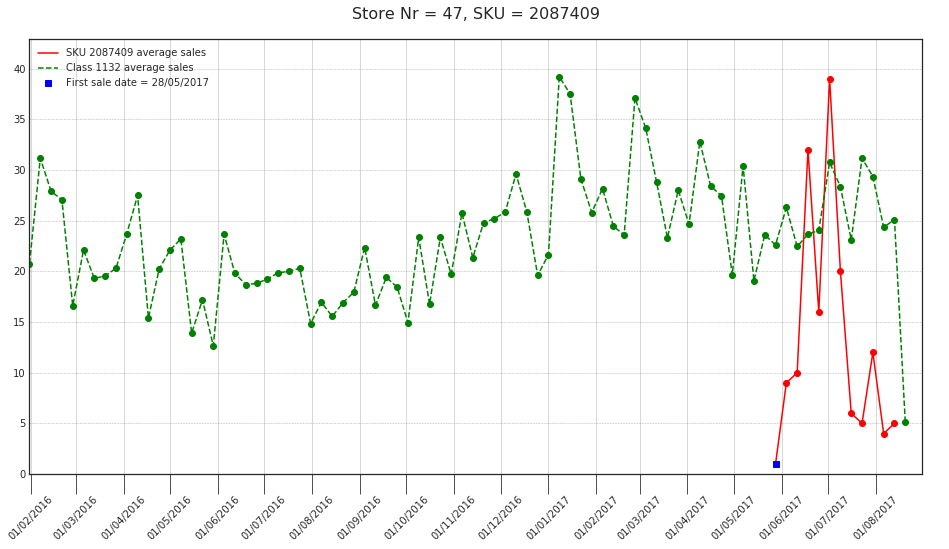

In [24]:
# Choose a single new item and plot its performance against items in the same class
def plot_sales_with_class_average(df, store_nr, item_nr):
    
    item_class = df[df['item_nbr']==item_nr]['class'].iloc[0]    
    data = df[df['class']==item_class].groupby(['item_nbr', 'date']).sum()['unit_sales']
    data = data.unstack(level=0)
    data.drop(columns=[item_nr], inplace=True)
    avg_sale = data.resample('W').sum().mean(axis=1)
        
    months = [datetime(2016, 1, 31, 0, 0) + relativedelta(months=i) for i in range(20)]
    x = df[(df['store_nbr'] == store_nr) & (df['item_nbr'] == item_nr)].groupby(['date'])['unit_sales'].sum().resample('W').sum().index
    y = df[(df['store_nbr'] == store_nr) & (df['item_nbr'] == item_nr)].groupby(['date'])['unit_sales'].sum().resample('W').sum().values
    
    with plt.style.context('seaborn-white'):
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.plot_date(mpl.dates.date2num(x), y, 'r-', label='SKU {} average sales'.format(item_nr))
        ax.plot_date(mpl.dates.date2num(x), y, 'ro')
        ax.plot_date(mpl.dates.date2num(avg_sale.index), avg_sale.values, 'g--', label='Class {} average sales'.format(item_class))
        ax.plot_date(mpl.dates.date2num(avg_sale.index), avg_sale.values, 'go')
        ax.plot_date(mpl.dates.date2num(x[0]), y[0], 'bs', label='First sale date = {}'.format(x[0].strftime('%d/%m/%Y')))
        ax.set_title('Store Nr = {}, SKU = {}'.format(store_nr, item_nr), pad = 20, fontdict = {'fontsize': 16})
        ax.set_ylim(0, max(y)*1.1)
        ax.set_xlim(months[0], months[-1])
        ax.xaxis.set_major_locator(MonthLocator())
        ax.xaxis.set_major_formatter(DateFormatter('%d/%m/%Y'))
        ax.xaxis.set_minor_locator(WeekdayLocator(byweekday=MO))
        ax.tick_params(axis = 'x', which = 'major', direction = 'out', length = 20, pad = 0, labelrotation = 45)
        ax.tick_params(axis = 'x', which = 'minor')
        ax.grid(axis = 'x', which = 'major', color='k', linestyle='-', linewidth=0.5, alpha=0.3)
        ax.grid(axis = 'y', which = 'major', color='k', linestyle='--', linewidth=0.5, alpha=0.3)
        ax.legend(loc = 'upper left')
        plt.show()
        
plot_sales_with_class_average(store_data , store_nr = 47, item_nr = 2087409)

In [28]:
def get_avg_sale(df, item_nbr):
    """Get average sale for all products in class"""
    item_class = df[df['item_nbr']==item_nbr]['class'].iloc[0]    
    data = df[df['class']==item_class].groupby(['item_nbr', 'date']).sum()['unit_sales']
    data = data.unstack(level=0)
    data.drop(columns=[item_nbr], inplace=True)
    avg_sale = data.mean(axis=1)
    return avg_sale

def get_product_performance(new_products, store_data):
    """Calculate sales performance of new products"""
    prod_performance = {}
    for prod in new_products:
        item_nbr = prod

        avg_sale = get_avg_sale(store_data, item_nbr = item_nbr)
        sku_sale = store_data[store_data['item_nbr'] == item_nbr].groupby(['date'])['unit_sales'].sum()

        avg_sale.rename('avg_class_sale', inplace=True)
        sku_sale.rename('sku_sale', inplace=True)

        first_date = sku_sale.index[0]
        last_date = sku_sale.index[-1]
        sales_comparison = pd.concat([avg_sale[first_date:last_date], sku_sale], axis=1)

        result = sales_comparison.mean(axis=0)
        sales_percent = result.iloc[1]/result.iloc[0]
        prod_performance[item_nbr] = sales_percent
        
        # Results has 2 NA SKU's (investigae why they are NA)
        results = pd.DataFrame.from_dict(prod_performance, orient='index').reset_index().dropna()
        results = results.sort_values(by=0, ascending=False).reset_index(drop=True)
        results.rename(index=str, columns={'index':'SKU', 0:'SCORE'}, inplace=True)
        
    return results

results = get_product_performance(new_products, store_data)

In [31]:
# Product perfromance df with products introduced in May
results.head()

,SKU,SCORE
0,2086882,2.891129
1,2112404,2.266693
2,2003392,2.013889
3,2087567,1.732656
4,2087374,1.602746


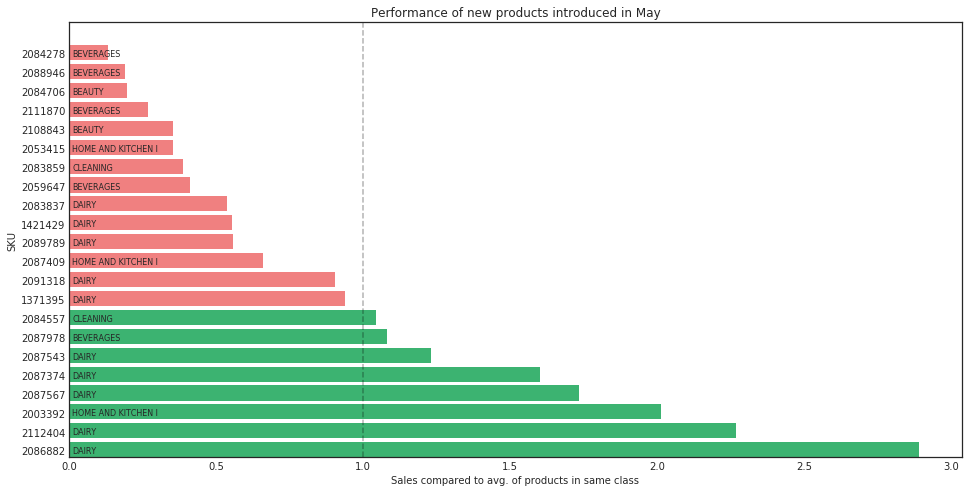

In [32]:
mask1 = results['SCORE']<=1
mask2 = results['SCORE']>1

with plt.style.context('seaborn-white'):
    fig, ax = plt.subplots(figsize=(16, 8))
    rects1 = ax.barh(results[mask2].index, results[mask2]['SCORE'], align='edge', color='mediumseagreen')
    rects2 = ax.barh(results[mask1].index, results[mask1]['SCORE'], align='edge', color='lightcoral')
    ax.plot(np.ones(results.shape[0]+2), list(range(results.shape[0]+2)), 'k--', alpha=0.3)
    ax.set_ylim(0, results.shape[0] + 1)
    ax.set_yticks([x+0.35 for x in range(results.shape[0])])
    ax.set_ylabel('SKU')
    ax.set_yticklabels(results['SKU'])
    ax.set_xlabel('Sales compared to avg. of products in same class')
    ax.set_title('Performance of new products introduced in May')
    
    def autolabel(rects):
        """Attach a text label on each bar displaying product family"""
        for i, rect in enumerate(rects):
            sku = results['SKU'].iloc[i]
            family = sku_family_df[sku]
            item_class = str(sku_class_df[sku])
            ax.text(0.01, rect.get_y()+0.2, family, fontdict = {'fontsize': 8})
            
    autolabel(rects1)
    autolabel(rects2)
    plt.show()

##  2.) Catalogue optimization for multiple stores

In [38]:
# Create a sale occurance matrix which will help us see when a certain product was introduced
all_agg = create_sale_occurance_matrix(data, data_type='all_stores')

In [40]:
# Get month of first occurance for each SKU
def get_month_of_first_appearance(df):
    """Return month of first appearance for all SKU's
    
    Parameters
    ----------
    df : DataFrame
        Sale count matrix where columns are SKU's and rows are counts of sale occurance in a month
    
    Return
    --------
    agg_df : dict
        Dictionary where keys are SKU's and values are months of first appearance
    """
    store = {}
    for store_nr in df.index.get_level_values(0).unique():
        df_store = df.loc[store_nr].copy()
        first_appearance = {}
        for item in df_store.columns:
            first_appearance[item] = (df_store[item] == 0).idxmin()
        store[store_nr] = first_appearance
    return store

first_appearance = get_month_of_first_appearance(all_agg)

In [50]:
def get_new_products(first_appearance, date):
    """Get new products for a given month
    
    Parameters
    ----------
    first_appearance : dict
        Dictionary where keys are store numbers and values are dictionaries 
        {store_nbr: {'SKU':introduction_date}}
    date : datetime
        Date when new items were introduced
        
    Return
    --------
    store_item_dict : dict
        {store_nbr:[list of new SKU's]}
    item_store_dict : dict
        {item_nbr:[list of new SKU's]}
    """
    store_item_dict = {}
    for store, item_dict in first_appearance.items():
        new_products = []
        for item, date in item_dict.items():
            if date == datetime(2017, 5, 31):
                new_products.append(item)
        store_item_dict[store] = new_products
                
    for key, value in store_item_dict.items():
        if key == 1:
            items = set(value)
        else:
            items = items.union(value)

    item_store_dict = {}
    for item in items:
        store_list = []
        for store, new_items in store_item_dict.items():
            if item in new_items:
                store_list.append(store)
            item_store_dict[item] = store_list
        
    return  item_store_dict, store_item_dict

item_store_dict, store_item_dict = get_new_products(first_appearance, date = datetime(2017, 5, 31))

In [59]:
store_item_dict

{1: [1360009,
  1421429,
  1463859,
  1463864,
  1489869,
  2017241,
  2017257,
  2028403,
  2053415,
  2058758,
  2067123,
  2072545,
  2075374,
  2083837,
  2083859,
  2084278,
  2084557,
  2084706,
  2086882,
  2087374,
  2087543,
  2087567,
  2088860,
  2089276,
  2089339,
  2090125,
  2099230,
  2101795,
  2103250,
  2108569],
 2: [1463619,
  1473499,
  2047496,
  2056557,
  2075374,
  2083837,
  2083859,
  2084278,
  2084557,
  2084706,
  2086882,
  2087374,
  2087409,
  2087543,
  2087567,
  2089789,
  2091318,
  2099230,
  2108843],
 3: [638327,
  1371395,
  1392260,
  1401733,
  1401735,
  1463864,
  1909770,
  2003392,
  2026858,
  2075374,
  2083837,
  2083859,
  2084278,
  2084557,
  2084706,
  2086882,
  2087374,
  2087409,
  2087543,
  2087567,
  2087978,
  2089250,
  2089276,
  2089789,
  2091318,
  2108843,
  2111870],
 4: [985823,
  1388568,
  1421429,
  1463859,
  1463864,
  1489869,
  1686644,
  1689929,
  1726000,
  2003392,
  2018753,
  2049037,
  2053630,
  205776

In [54]:
def get_average_sales(data, item_nbr, item_store_dict):
    item_class = data[data['item_nbr']==item_nbr]['class'].iloc[0]
    cond_1 = data['class'] == item_class
    cond_2 = data['item_nbr'] != item_nbr
    cond_3 = data['store_nbr'].isin(item_store_dict[item_nbr])
    
    df_class = data[(cond_1)&(cond_2)&(cond_3)].copy()
    df_class = df_class.groupby(['store_nbr', 'item_nbr', 'date'])['unit_sales'].sum().unstack(level=[0, 1])
    avg_class_sale = df_class.mean(axis=1)
    
    df_sku = data[(cond_1)&(data['item_nbr'] == item_nbr)&(cond_3)].copy()
    df_sku = df_sku.groupby(['store_nbr', 'item_nbr', 'date'])['unit_sales'].sum().unstack(level=[0, 1])
    avg_sku_sale = df_sku.mean(axis=1)
    return avg_class_sale, avg_sku_sale

def get_product_performance(item_store_dict, data):
    """Calculate sales performance of new products
    Performance is defined as total sales compared to avg. sales of other items in same class
    """
    prod_performance = {}
    for item_nbr in item_store_dict.keys():
        avg_class_sale, avg_sku_sale = get_average_sales(data, item_nbr, item_store_dict)

        avg_class_sale.rename('avg_class_sale', inplace=True)
        avg_sku_sale.rename('avg_sku_sale', inplace=True)

        first_date = avg_sku_sale.index[0]
        last_date = avg_sku_sale.index[-1]
        sales_comparison = pd.concat([avg_class_sale[first_date:last_date], avg_sku_sale], axis=1)

        result = sales_comparison.mean(axis=0)
        sales_percent = result.iloc[1]/result.iloc[0]
        prod_performance[item_nbr] = sales_percent
        
    results = pd.DataFrame.from_dict(prod_performance, orient='index').reset_index().dropna()
    results = results.sort_values(by=0, ascending=False).reset_index(drop=True)
    results.rename(index=str, columns={'index':'SKU', 0:'SCORE'}, inplace=True)
    return results
    
results = get_product_performance(item_store_dict, data)

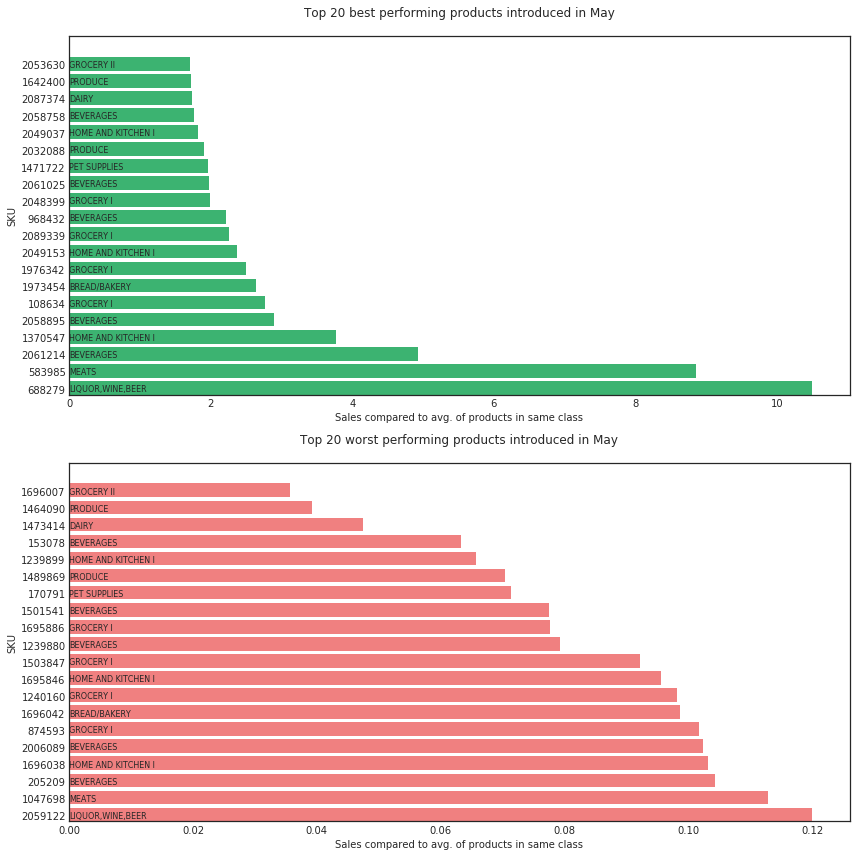

In [57]:
def plot_top_and_bottom_product(results, top_and_bottom=20):
    results = pd.concat([results.iloc[:top_and_bottom, :], results.iloc[-top_and_bottom:, :]]).reset_index(drop=True)
    mask1 = results['SCORE']>1
    mask2 = results['SCORE']<=1
    with plt.style.context('seaborn-white'):
        fig, (ax1, ax2)  = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))
        rects1 = ax1.barh(list(range(results[mask1].shape[0])), results[mask1]['SCORE'], align='edge', color='mediumseagreen')
        rects2 = ax2.barh(list(range(results[mask2].shape[0])), results[mask2]['SCORE'], align='edge', color='lightcoral')

        ax1.set_ylim(0, results[mask1].shape[0] + 1)
        ax1.set_yticks([x+0.35 for x in range(results[mask1].shape[0])])
        ax1.set_ylabel('SKU')
        ax1.set_yticklabels(results[mask1]['SKU'])
        ax1.set_xlabel('Sales compared to avg. of products in same class')
        ax1.set_title('Top {} best performing products introduced in May'.format(top_and_bottom), pad=20)

        ax2.set_ylim(0, results[mask2].shape[0] + 1)
        ax2.set_yticks([x+0.35 for x in range(results[mask2].shape[0])])
        ax2.set_ylabel('SKU')
        ax2.set_yticklabels(results[mask2]['SKU'])
        ax2.set_xlabel('Sales compared to avg. of products in same class')
        ax2.set_title('Top {} worst performing products introduced in May'.format(top_and_bottom), pad=20)

        def autolabel(rects, ax):
            """Attach a text label on each bar displaying product family"""
            for i, rect in enumerate(rects):
                sku = results['SKU'].iloc[i]
                family = sku_family_df[sku]
                item_class = str(sku_class_df[sku])
                ax.text(rect.get_x()*1.05, rect.get_y()+0.2, family, fontdict = {'fontsize': 8})

        autolabel(rects1, ax=ax1)
        autolabel(rects2, ax=ax2)
        plt.tight_layout()
        plt.show()
        
plot_top_and_bottom_product(results, top_and_bottom=20)

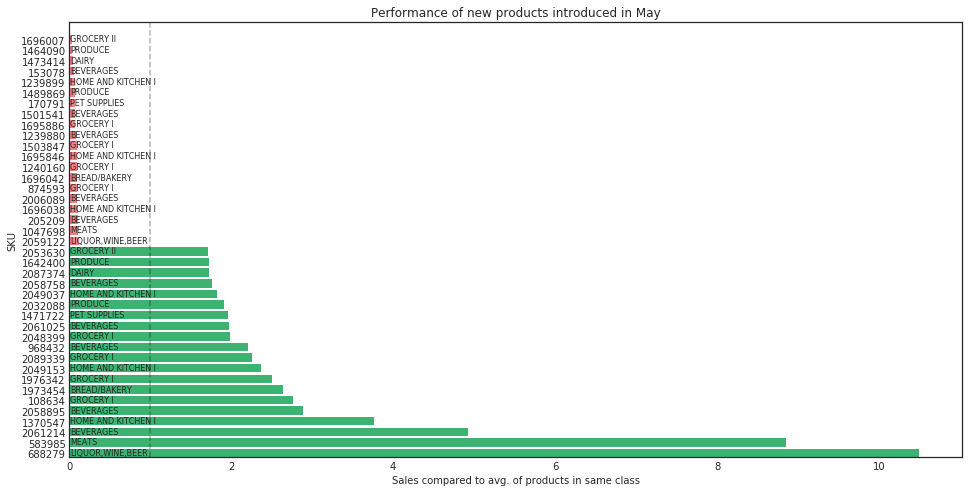

In [935]:
# plot_top_and_bottom(results, top_and_bottom=20):
top_and_bottom=30
results = pd.concat([results.iloc[:top_and_bottom, :], results.iloc[-top_and_bottom:, :]]).reset_index(drop=True)
mask1 = results['SCORE']<=1
mask2 = results['SCORE']>1

with plt.style.context('seaborn-white'):
    fig, ax = plt.subplots(figsize=(16, 8))
    rects1 = ax.barh(results[mask2].index, results[mask2]['SCORE'], align='edge', color='mediumseagreen')
    rects2 = ax.barh(results[mask1].index, results[mask1]['SCORE'], align='edge', color='lightcoral')
    ax.plot(np.ones(results.shape[0]+2), list(range(results.shape[0]+2)), 'k--', alpha=0.3)
    ax.set_ylim(0, results.shape[0] + 1)
    ax.set_yticks([x+0.35 for x in range(results.shape[0])])
    ax.set_ylabel('SKU')
    ax.set_yticklabels(results['SKU'])
    ax.set_xlabel('Sales compared to avg. of products in same class')
    ax.set_title('Performance of new products introduced in May')
    
    def autolabel(rects):
        """Attach a text label on each bar displaying product family"""
        for i, rect in enumerate(rects):
            sku = results['SKU'].iloc[i]
            family = sku_family_df[sku]
            item_class = str(sku_class_df[sku])
            ax.text(0.01, rect.get_y()+0.2, family, fontdict = {'fontsize': 8})
            
    autolabel(rects1)
    autolabel(rects2)
    plt.show()

# 3.) Other useful plots

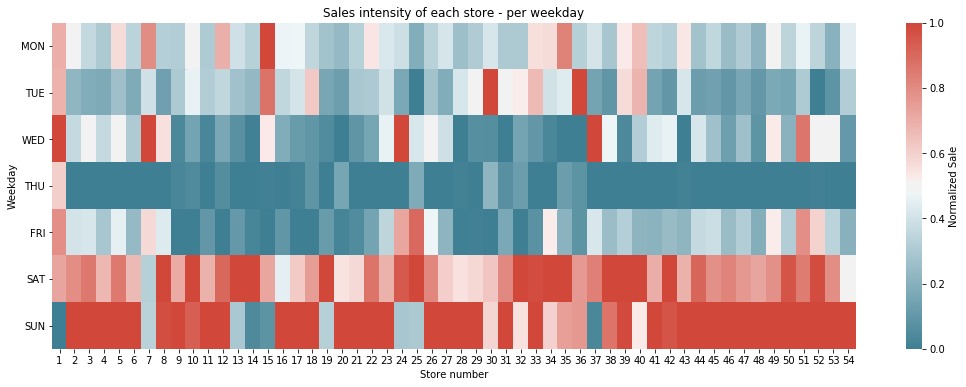

In [884]:
cmap = sns.diverging_palette(220, 15, as_cmap=True)

data['weekday'] = [item.weekday() for item in data['date']]
stores_weekday_df = data.groupby(['store_nbr', 'weekday']).sum().reset_index()
stores_weekday_df = stores_weekday_df.pivot(index='weekday', columns='store_nbr', values='unit_sales')

fig, ax = plt.subplots(figsize=(18, 6))
sns.heatmap(df_stores_weekday.apply(lambda col: (col-min(col))/(max(col)-min(col)), axis=0),
            cmap=cmap,
            cbar_kws={'label': 'Normalized Sale'},
            ax=ax)
ax.set_ylabel('Weekday')
ax.set_xlabel('Store number')
ax.set_yticklabels(['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN'])
ax.set_title('Sales intensity of each store - per weekday')
plt.yticks(rotation=0)
plt.show()

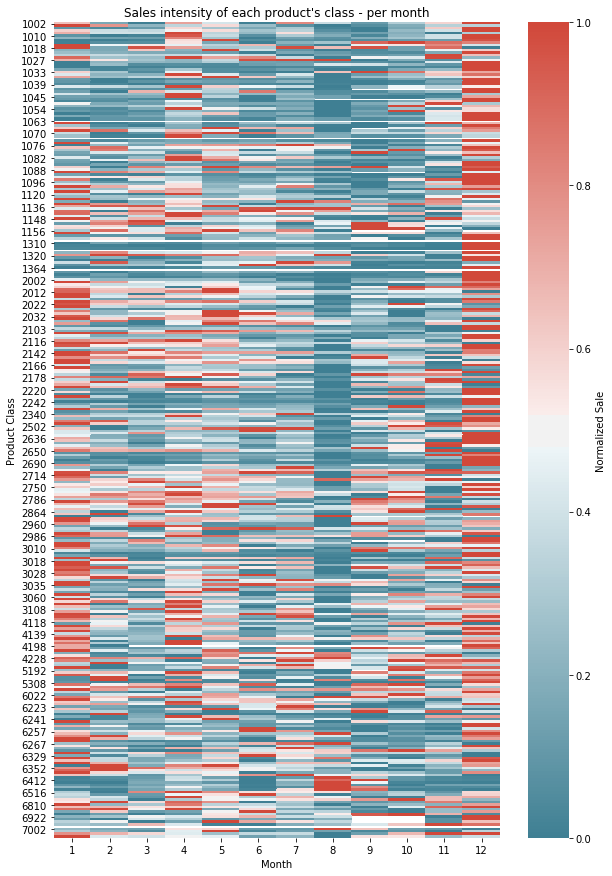

In [885]:
data['month'] = [item.month for item in data['date']]
df_item_month = data.groupby(['class', 'month'])['unit_sales'].mean().reset_index()
df_item_month = df_item_month.pivot(index='month', columns='class', values='unit_sales')

fig, ax = plt.subplots(figsize=(10,15))
sns.heatmap(df_item_month.apply(lambda col: (col-min(col))/(max(col)-min(col)), axis=0).T,
            cmap=cmap,
            cbar_kws={'label': 'Normalized Sale'},
            ax=ax)
ax.set_ylabel('Product Class')
ax.set_xlabel('Month')
ax.set_title("Sales intensity of each product's class - per month")
plt.show()

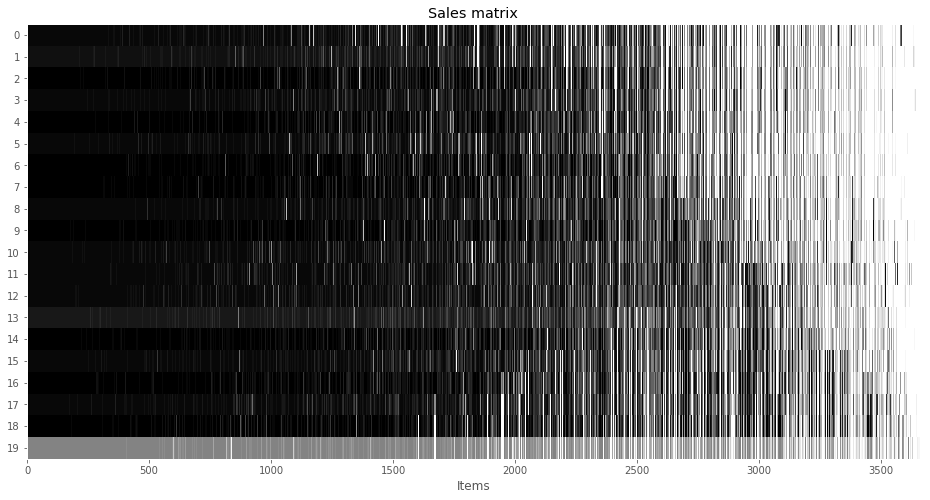

In [258]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_sales_matrix(df):
    cols = df.sum(axis=0).sort_values(ascending=False).index.tolist()
    df = df[cols]

    y_ticklabels = list(map(lambda x: x.strftime('%Y/%m/%d'), df.index))
    y_ticks = list(range(len(y_ticklabels)))

    with plt.style.context('ggplot'):
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.imshow(df.values, aspect = 'auto', vmin=0, vmax=31, cmap='binary')
        ax.grid()
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(y_ticks)
        ax.set_xlabel('Items')
        ax.set_title('Sales matrix')
        plt.show()
        
plot_sales_matrix(df_agg)

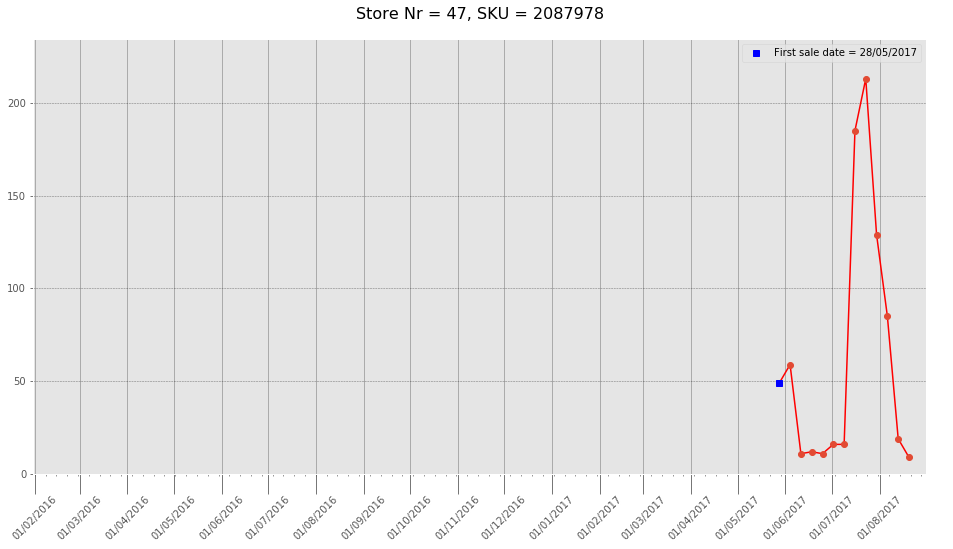

In [20]:
# plot weekly sales for a single product at a single store

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.dates import WeekdayLocator, YearLocator, MonthLocator, DateFormatter
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
from datetime import datetime
from dateutil.relativedelta import relativedelta

def plot_sales(df, store_nr, item_nr):
    
    months = [datetime(2016, 1, 31, 0, 0) + relativedelta(months=i) for i in range(20)]
    x = df[(df['store_nbr'] == store_nr) & (df['item_nbr'] == item_nr)].groupby(['date'])['unit_sales'].sum().resample('W').sum().index
    y = df[(df['store_nbr'] == store_nr) & (df['item_nbr'] == item_nr)].groupby(['date'])['unit_sales'].sum().resample('W').sum().values

    with plt.style.context('ggplot'):
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.plot_date(mpl.dates.date2num(x), y, 'r-')
        ax.plot_date(mpl.dates.date2num(x), y, 'o')
        ax.plot_date(mpl.dates.date2num(x[0]), y[0], 'bs', label='First sale date = {}'.format(x[0].strftime('%d/%m/%Y')))
        ax.set_title('Store Nr = {}, SKU = {}'.format(store_nr, item_nr), pad = 20, fontdict = {'fontsize': 16})
        ax.set_ylim(0, max(y)*1.1)
        ax.set_xlim(months[0], months[-1])
        ax.xaxis.set_major_locator(MonthLocator())
        ax.xaxis.set_major_formatter(DateFormatter('%d/%m/%Y'))
        ax.xaxis.set_minor_locator(WeekdayLocator(byweekday=MO))
        ax.tick_params(axis = 'x', which = 'major', direction = 'out', length = 20, pad = 0, labelrotation = 45)
        ax.tick_params(axis = 'x', which = 'minor')
        ax.grid(axis = 'x', which = 'major', color='k', linestyle='-', linewidth=0.5, alpha=0.5)
        ax.grid(axis = 'y', which = 'major', color='k', linestyle='--', linewidth=0.5, alpha=0.5)
        ax.legend()
        plt.show()

plot_sales(data, store_nr = 47, item_nr = 2087978)